In [1]:
# # Selection on Observables
# ## Purpose
# The purpose of this notebook is to illustrate an example of the workflow outlined in [Brathwaite and Walker (2017)](https://arxiv.org/abs/1706.07502). This simple application aims at highlighting the importance of causal structure in estimating causal effects of interest reflecting changes resulting from policy proposals. The basic idea is to show that when we control for intermediate variables of some variable of interest in a causal graph, we never recover the true causal parameter on the variable of interest.
#
# This notebook uses the dataset and the MNL utility specification from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900) for demonstration.
# The rest of the notebook is organized as follows:
#  - Defining different causal graphs representing different views for how individuals make mode choices. These causal graphs are based on the MNL utility functions from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900)
#  - Simulating data based on the different beliefs about the data generating process illustrated by both causal graphs.
#  - Perturbing one of the variables (e.g.: Travel Distance) to simulate a policy intervention.
#  - Calculating and plotting the distributions of treatment effects according to different causal graphs.
# # Import Needed Libraries

In [2]:
# Built-in libraries
import copy
import sys
from collections import defaultdict
from collections import OrderedDict
from functools import reduce

import causal2020.observables.availability as av
import causal2020.observables.distfit as distfit
import causal2020.observables.regression as reg
import causal2020.observables.simulation as sim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylogit as pl
import seaborn as sns
from causal2020.observables.graphs import BIKE_UTILITY
from causal2020.observables.graphs import DA_UTILITY
from causal2020.observables.graphs import DTW_UTILITY
from causal2020.observables.graphs import IND_UTILITY
from causal2020.observables.graphs import SHARED_2_UTILITY
from causal2020.observables.graphs import SHARED_3P_UTILITY
from causal2020.observables.graphs import WALK_UTILITY
from causal2020.observables.graphs import WTD_UTILITY
from causal2020.observables.graphs import WTW_UTILITY
from causal2020.observables.utils import is_notebook
from causalgraphicalmodels import CausalGraphicalModel
from checkrs.utils import simulate_choice_vector
from pyprojroot import here

# Third party libraries
# Local libraries

# Set Notebook Parameters

In [3]:
SEED = 197
np.random.seed(SEED)

# Path to Data
DATA_PATH = here(
    "data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv"
)

# Path to computational code used
# in simulation loop
SIMULATE_NODES_WIDE = open(
    here("src/causal2020/observables/simworkflow.py")
).read()
SIMULATE_PERTURB = open(
    here("src/causal2020/observables/simperturb.py")
).read()

# Path to storage location for plots with results
TRUE_VS_NAIVE_PLOT_PATH = here("article/images/histogram_selection_on_obs.pdf")
TRUE_VS_ESTIMATED_PLOT_PATH = here(
    "reports/figures/historgram_true_vs_estimated_effects.pdf"
)

In [4]:
# Alternative id column from long format data
ALT_ID_COL = "mode_id"

# Individual specific variables list
IND_SPEC_VARS = [
    "household_size",
    "num_kids",
    "num_cars",
    "num_licensed_drivers",
]

# Alternative specific variables dictionary
# Key is alternative number, value is a list
# of alternative specific nodes without parents
ALT_SPEC_DICT = {
    1: ["total_travel_distance"],
    2: ["total_travel_distance"],
    3: ["total_travel_distance"],
    4: ["total_travel_time"],
    5: ["total_travel_time"],
    6: ["total_travel_time"],
    7: ["total_travel_distance"],
    8: ["total_travel_distance"],
}

# Trip specific variables list
TRIP_SPEC_VARS = ["cross_bay"]

# Alternative name dictionary
# Key is alternative number
# value is alternative number snake cased
ALT_NAME_DICT = {
    1: "drive_alone",
    2: "shared_2",
    3: "shared_3p",
    4: "wtw",
    5: "dtw",
    6: "wtd",
    7: "walk",
    8: "bike",
}

ALT_ID_TO_MODE_NAME = {
    1: "Drive Alone",
    2: "Shared Ride 2",
    3: "Shared Ride 3+",
    4: "Walk-Transit-Walk",
    5: "Drive-Transit-Walk",
    6: "Walk-Transit-Drive",
    7: "Walk",
    8: "Bike",
}

# Variable type Dictionary
# Key is string with variable name from previous
# dictionaries and lists, value is a string
# with type of the variable
VARS_TYPE = {
    "num_kids": "categorical",
    "household_size": "categorical",
    "num_cars": "categorical",
    "num_licensed_drivers": "categorical",
    "cross_bay": "categorical",
    "total_travel_time": "continuous",
    "total_travel_distance": "continuous",
    "total_travel_cost": "continuous",
}

# Distribution to be explored for continuous variables
CONT_DISTS = ["norm", "alpha", "beta", "gamma", "expon", "gumbel"]

In [5]:
# Declare regression parameters

REGS_DA = {
    1: ("total_travel_distance", "total_travel_cost"),
    2: ("total_travel_distance", "total_travel_time"),
}

REGS_TYPE_DA = {1: "linear", 2: "linear"}


REGS_SHARED_2 = {
    1: ("total_travel_distance", "total_travel_cost"),
    2: ("total_travel_distance", "total_travel_time"),
}

REGS_TYPE_SHARED_2 = {1: "linear", 2: "linear"}


REGS_SHARED_3P = {
    1: ("total_travel_distance", "total_travel_cost"),
    2: ("total_travel_distance", "total_travel_time"),
}

REGS_TYPE_SHARED_3P = {1: "linear", 2: "linear"}


REGS_WTW = {1: ("total_travel_time", "total_travel_cost")}

REGS_TYPE_WTW = {1: "linear"}


REGS_DTW = {1: ("total_travel_time", "total_travel_cost")}

REGS_TYPE_DTW = {1: "linear"}


REGS_WTD = {1: ("total_travel_time", "total_travel_cost")}

REGS_TYPE_WTD = {1: "linear"}

In [6]:
# Parameters for conversion from Wide to Long

IND_VARIABLES = [
    "num_kids",
    "household_size",
    "num_cars",
    "num_licensed_drivers",
    "cross_bay",
]


# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
ALT_VARYING_VARIABLES = {
    "total_travel_time": dict(
        [
            (1, "total_travel_time_drive_alone"),
            (2, "total_travel_time_shared_2"),
            (3, "total_travel_time_shared_3p"),
            (4, "total_travel_time_wtw"),
            (5, "total_travel_time_dtw"),
            (6, "total_travel_time_wtd"),
        ]
    ),
    "total_travel_cost": dict(
        [
            (1, "total_travel_cost_drive_alone"),
            (2, "total_travel_cost_shared_2"),
            (3, "total_travel_cost_shared_3p"),
            (4, "total_travel_cost_wtw"),
            (5, "total_travel_cost_dtw"),
            (6, "total_travel_cost_wtd"),
        ]
    ),
    "total_travel_distance": dict(
        [
            (1, "total_travel_distance_drive_alone"),
            (2, "total_travel_distance_shared_2"),
            (3, "total_travel_distance_shared_3p"),
            (7, "total_travel_distance_walk"),
            (8, "total_travel_distance_bike"),
        ]
    ),
}


# Dictionary of alternative availability variables
AVAILABILITY_VARIABLES = {
    1: "drive_alone_AV",
    2: "shared_2_AV",
    3: "shared_3p_AV",
    4: "wtw_AV",
    5: "dtw_AV",
    6: "wtd_AV",
    7: "walk_AV",
    8: "bike_AV",
}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
CUSTOM_ALT_ID = "mode_id"

OBS_ID_COL = "observation_id"

# Declare choice column
CHOICE_COL = "sim_choice"

In [7]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

MNL_SPECIFICATION = OrderedDict()
MNL_NAMES = OrderedDict()

MNL_SPECIFICATION["intercept"] = [2, 3, 4, 5, 6, 7, 8]
MNL_NAMES["intercept"] = [
    "ASC Shared Ride: 2",
    "ASC Shared Ride: 3+",
    "ASC Walk-Transit-Walk",
    "ASC Drive-Transit-Walk",
    "ASC Walk-Transit-Drive",
    "ASC Walk",
    "ASC Bike",
]

MNL_SPECIFICATION["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
MNL_NAMES["total_travel_time"] = [
    "Travel Time, units:min (All Auto Modes)",
    "Travel Time, units:min (All Transit Modes)",
]

MNL_SPECIFICATION["total_travel_cost"] = [[4, 5, 6]]
MNL_NAMES["total_travel_cost"] = ["Travel Cost, units:$ (All Transit Modes)"]

MNL_SPECIFICATION["cost_per_distance"] = [1, 2, 3]
MNL_NAMES["cost_per_distance"] = [
    "Travel Cost per Distance, units:$/mi (Drive Alone)",
    "Travel Cost per Distance, units:$/mi (SharedRide-2)",
    "Travel Cost per Distance, units:$/mi (SharedRide-3+)",
]

MNL_SPECIFICATION["cars_per_licensed_drivers"] = [[1, 2, 3]]
MNL_NAMES["cars_per_licensed_drivers"] = [
    "Autos per licensed drivers (All Auto Modes)"
]

MNL_SPECIFICATION["total_travel_distance"] = [7, 8]
MNL_NAMES["total_travel_distance"] = [
    "Travel Distance, units:mi (Walk)",
    "Travel Distance, units:mi (Bike)",
]

MNL_SPECIFICATION["cross_bay"] = [1, [2, 3]]
MNL_NAMES["cross_bay"] = [
    "Cross-Bay Tour (Drive Alone)",
    "Cross-Bay Tour (Shared Ride 2 & 3+)",
]

MNL_SPECIFICATION["household_size"] = [[2, 3]]
MNL_NAMES["household_size"] = ["Household Size (Shared Ride 2 & 3+)"]

MNL_SPECIFICATION["num_kids"] = [[2, 3]]
MNL_NAMES["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

# Load and Describe Data

In [8]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(DATA_PATH)

# Look at the mode shares in the data set

mode_counts = (
    bike_data_long.loc[bike_data_long.choice == 1, "mode_id"]
    .value_counts()
    .loc[range(1, 9)]
)

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [ALT_ID_TO_MODE_NAME[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

# Choice Model Estimation

For purposes of this task, we use the MNL specification from Brathwaite and Walker (2016) and estimate the model resulting from such a specification. We assume that the estimated model parameters represent the "true" model parameters.

In [9]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(
    data=bike_data_long,
    alt_id_col=ALT_ID_COL,
    obs_id_col=OBS_ID_COL,
    choice_col="choice",
    specification=MNL_SPECIFICATION,
    model_type="MNL",
    names=MNL_NAMES,
)

num_vars = len(reduce(lambda x, y: x + y, MNL_NAMES.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars), method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/scipy/optimize/_minimize.py:523: RuntimeWarning: Method BFGS does not use Hessian information (hess).


Estimation Time for Point Estimation: 0.26 seconds.
Final log-likelihood: -5,071.8150


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,984
Method:                                MLE   Df Model:                           20
Date:                     Sun, 20 Dec 2020   Pseudo R-squ.:                   0.333
Time:                             15:08:09   Pseudo R-bar-squ.:               0.330
AIC:                            10,183.630   Log-Likelihood:             -5,071.815
BIC:                            10,309.531   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -0.8565      0.494     -1.735      0.083      -1.824       0.111
ASC Shared Ride: 3+                                      3.2543      1.058      3.076      0.002       1.180       5.328
ASC Walk-Transit-Walk                                    0.1324      0.414      0.320      0.749      -0.678       0.943
ASC Drive-Transit-Walk                                  -2.0873      0.427     -4.886      0.000      -2.925      -1.250
ASC Walk-Transit-Drive                                  -2.4391      0.431     -5.660      0.000      -3.284      -1.595
ASC Walk                                                 2.0787      0.424      4.906      0.000       1.248       2.909
ASC Bike                                                -0.5781      0.425     -1.360      0.174      -1.411       0.255
Travel Time, units:min (All Auto Modes)                 -0.0742      0.006    -13.135      0.000      -0.085      -0.063
Travel Time, units:min (All Transit Modes)              -0.0268      0.002    -12.328      0.000      -0.031      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1322      0.037     -3.570      0.000      -0.205      -0.060
Travel Cost per Distance, units:$/mi (Drive Alone)      -2.2541      2.093     -1.077      0.281      -6.356       1.848
Travel Cost per Distance, units:$/mi (SharedRide-2)    -16.8543      4.927     -3.421      0.001     -26.510      -7.198
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -81.1009     15.551     -5.215      0.000    -111.580     -50.621
Autos per licensed drivers (All Auto Modes)              1.2108      0.129      9.393      0.000       0.958       1.463
Travel Distance, units:mi (Walk)                        -1.0230      0.050    -20.330      0.000      -1.122      -0.924
Travel Distance, units:mi (Bike)                        -0.2840      0.024    -11.733      0.000      -0.331      -0.237
Cross-Bay Tour (Drive Alone)                            -0.6425      0.360     -1.784      0.074      -1.348       0.063
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.5106      0.402      1.270      0.204      -0.277       1.299
Household Size (Shared Ride 2 & 3+)                      0.1141      0.045      2.535      0.011       0.026       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6865      0.054     12.816      0.000       0.581       0.791
========================================================================================================================
"""

# Show Causal Graphs

We generate two causal graphs based on the data at hand and the specified utility functions from above:

 * An "independent" causal graph: All nodes are independent and do not affect each other. Any change in any variable in the graph would not result in changes in other variables and would only affect the value of the utility function.
 * A "realistic" causal graph: The structure of this causal graph shows that some variables affect others. In this example, a change in travel distance affects travel time, travel cosst, and directly affects the utility function.

The outcome of each of the causal graphs is the utility of each variable. As such, we generate causal graphs based on the utility specification for each alternative.

## Independent Causal Graph

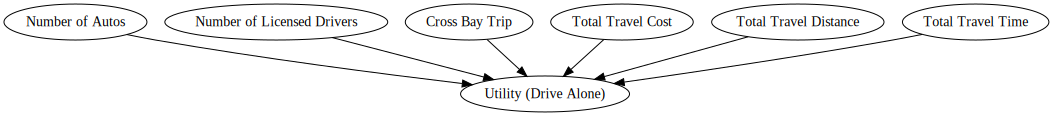

In [10]:
IND_UTILITY.draw()

## Realistic Causal Graphs

## Drive Alone

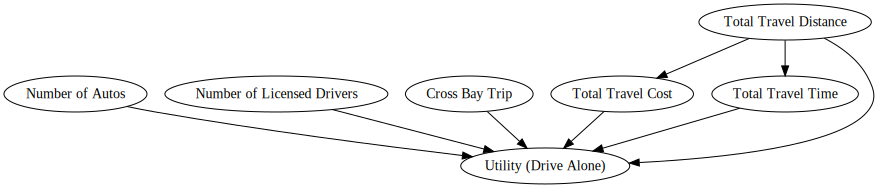

In [11]:
DA_UTILITY.draw()

## Shared-2

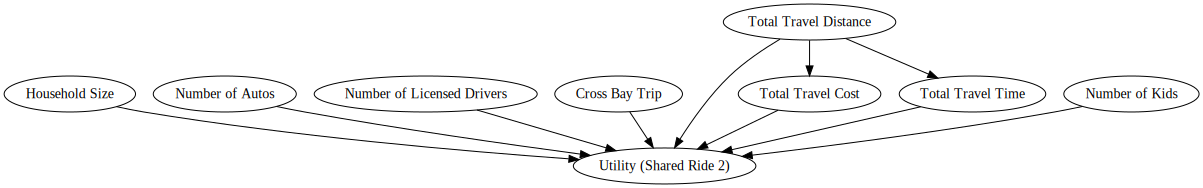

In [12]:
SHARED_2_UTILITY.draw()

## Shared-3+

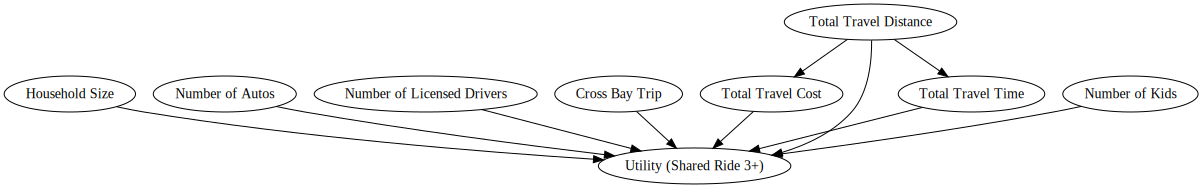

In [13]:
SHARED_3P_UTILITY.draw()

## Walk-Transit-Walk

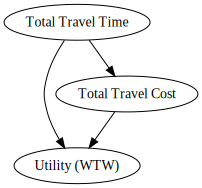

In [14]:
WTW_UTILITY.draw()

## Drive-Transit-Walk

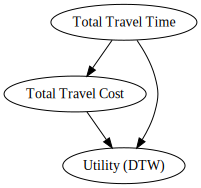

In [15]:
DTW_UTILITY.draw()

##  Walk-Transit-Drive

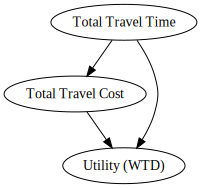

In [16]:
WTD_UTILITY.draw()

## Walk

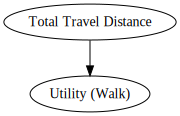

In [17]:
WALK_UTILITY.draw()

## Bike

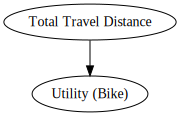

In [18]:
BIKE_UTILITY.draw()

# Selection on Observables Simulation

We simulate data based on the assumed structure of the causal diagrams and the original data from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900). This process goes as follows:

For the independent causal graph:
 * We fit a probability distribution for all the nodes in the utility function

For the realistic causal graph:
 * We fit a probability distribution for all the nodes without any parents/upstream notes in the causal graphs
 * We fit any regressions between the related explanatory variables

Based on these fitted distributions and regressions, we can then simulate data for the remaining nodes in each of the alternatives in our specified model.

## Distribution Fitting

In [19]:
bike_data_params = distfit.get_dist_node_no_parent(
    bike_data_long,
    ALT_ID_COL,
    OBS_ID_COL,
    ALT_SPEC_DICT,
    ALT_NAME_DICT,
    IND_SPEC_VARS,
    TRIP_SPEC_VARS,
    VARS_TYPE,
    CONT_DISTS,
)

Getting Distributions of Individual Specific Variables...
---------------------------------------------------------
Done...
Getting Distributions of Alternative Specific Variables...
----------------------------------------------------------


Done...
Getting Distributions of Trip Specific Variables...
---------------------------------------------------------
Done...


## Regression Fitting

Based on the structure of the "realistic" causal graphs assumed for each of the alternatives, we fit regressions that will allow us to simulate the remaining nodes in the causal graphs. The utility node will be simulated based on the utility function for each alternative.

## Drive Alone

In [20]:
drive_alone_df = bike_data_long.loc[bike_data_long["mode_id"] == 1]

drive_alone_df.reset_index(drop=True, inplace=True)

fitted_reg_da = reg.fit_alternative_regression(
    regressions=REGS_DA, reg_types=REGS_TYPE_DA, data=drive_alone_df
)

## Shared-2

In [21]:
shared_2_df = bike_data_long.loc[bike_data_long["mode_id"] == 2]

shared_2_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_2 = reg.fit_alternative_regression(
    regressions=REGS_SHARED_2, reg_types=REGS_TYPE_SHARED_2, data=shared_2_df
)

## Shared-3+

In [22]:
shared_3p_df = bike_data_long.loc[bike_data_long["mode_id"] == 3]

shared_3p_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_3p = reg.fit_alternative_regression(
    regressions=REGS_SHARED_3P,
    reg_types=REGS_TYPE_SHARED_3P,
    data=shared_3p_df,
)

## Walk-Transit-Walk

In [23]:
wtw_df = bike_data_long.loc[bike_data_long["mode_id"] == 4]

wtw_df.reset_index(drop=True, inplace=True)

fitted_reg_wtw = reg.fit_alternative_regression(
    regressions=REGS_WTW, reg_types=REGS_TYPE_WTW, data=wtw_df
)

## Drive-Transit-Walk

In [24]:
dtw_df = bike_data_long.loc[bike_data_long["mode_id"] == 5]

dtw_df.reset_index(drop=True, inplace=True)

fitted_reg_dtw = reg.fit_alternative_regression(
    regressions=REGS_DTW, reg_types=REGS_TYPE_DTW, data=dtw_df
)

## Walk-Transit-Drive

In [25]:
wtd_df = bike_data_long.loc[bike_data_long["mode_id"] == 6]

wtd_df.reset_index(drop=True, inplace=True)

fitted_reg_wtd = reg.fit_alternative_regression(
    regressions=REGS_WTD, reg_types=REGS_TYPE_WTD, data=wtd_df
)

## Simulation

Identifying the probability distributions of parent nodes and identifying the relationships between connected nodes allows us to complete the selection-on-observables simulation. The workflow proceeds as follows:
* Simulate two sets of data for the X variables:
  - One where all the Xs are independent (i.e. the only edges in the causal graph are between the X and the outcome variable (which is the value of the utility function)).
  - One based on a realistic causal graph with confounders. The confounder in this simple example is Travel Distance.
* For each of the two causal graphs mentioned in the previous step, simulate choice data based on the outcome model assumed from [Brathwaite and Walker (2016)](https://arxiv.org/abs/1606.05900).
* Estimate the choice model for each of those two datasets using the assumed choice model specification.
* Apply the do-operator (perturbation) to the variable of interest (Travel Distance), and show that the predicted outcome would be accurate only if our causal graph captures the dependency between the explanatory variables.

### Simulation Parameters

In [26]:
# In general, we want 200 simulations, but if we're using this file as a python
# script in a CI, use 30 simulations so the CI terminates quickly.
NUM_SIMULATIONS = 200 if is_notebook() else 30
simulation_sizes = np.random.randint(low=3000, high=4000, size=NUM_SIMULATIONS)
sim_number = np.arange(1, 1 + NUM_SIMULATIONS)
models_dictionary = defaultdict(dict)
causal_effect_dictionary = {}
perturb = 0.8
simulation_data = {}
causal_effects = pd.DataFrame(
    columns=["naive_effect", "true_effect", "estimated_effect"]
)

In [27]:
for sim_size, number in zip(simulation_sizes, sim_number):
    print(f"Simulation number {number} of {NUM_SIMULATIONS} is in progress...")
    print("Simulation size is", sim_size)
    print("------------------------------------------")
    print("Simulating data...")
    # Simulate data without parents
    sim_bike_data_no_parent = sim.sim_node_no_parent(
        params_dict=bike_data_params, size=sim_size
    )

    sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

    # Simulate nodes based on causal graphs
    exec(SIMULATE_NODES_WIDE)

    # Converting Data from Wide to Long
    print("Converting data from wide to long...")
    long_sim_data = pl.convert_wide_to_long(
        wide_data=sim_bike_data_wide,
        ind_vars=IND_VARIABLES,
        alt_specific_vars=ALT_VARYING_VARIABLES,
        availability_vars=AVAILABILITY_VARIABLES,
        obs_id_col=OBS_ID_COL,
        choice_col=CHOICE_COL,
        new_alt_id_name=CUSTOM_ALT_ID,
    )

    # Create a cars per licensed drivers column
    long_sim_data["cars_per_licensed_drivers"] = 0
    long_sim_data.loc[
        long_sim_data.num_licensed_drivers > 0, "cars_per_licensed_drivers"
    ] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(
        float
    )

    # Add a variable representing cost divided by distance
    long_sim_data["cost_per_distance"] = 0
    long_sim_data.loc[
        long_sim_data.mode_id.isin([1, 2, 3]), "cost_per_distance"
    ] = (
        long_sim_data.loc[
            long_sim_data.mode_id.isin([1, 2, 3]), "total_travel_cost"
        ]
        / long_sim_data.loc[
            long_sim_data.mode_id.isin([1, 2, 3]), "total_travel_distance"
        ]
    )

    # Simulating Choices
    print("Simulating Choices...")
    # Calculate probabilities for each alternative
    # based on the estimated model
    init_mnl_model_probs = mnl_model.predict(long_sim_data)

    # Simulate choice data
    long_sim_data[CHOICE_COL] = simulate_choice_vector(
        predicted_probs=init_mnl_model_probs,
        observation_ids=long_sim_data[OBS_ID_COL].values,
    )

    # Estimating Choice Models
    print("Estimating the choice model...")
    # Estimate the basic MNL model, using the hessian and newton-conjugate gradient
    mnl_model_sim = pl.create_choice_model(
        data=long_sim_data,
        alt_id_col=ALT_ID_COL,
        obs_id_col=OBS_ID_COL,
        choice_col=CHOICE_COL,
        specification=MNL_SPECIFICATION,
        model_type="MNL",
        names=MNL_NAMES,
    )

    num_vars = len(reduce(lambda x, y: x + y, MNL_NAMES.values()))
    # Note newton-cg used to ensure convergence to a point where gradient
    # is essentially zero for all dimensions.
    mnl_model_sim_params = mnl_model_sim.fit_mle(
        np.zeros(num_vars), method="BFGS", just_point=True
    )
    mnl_model_sim_param_list = [mnl_model_sim_params["x"], None, None, None]
    models_dictionary[number] = mnl_model_sim

    print("Estimating Causal Effects...")

    # Estimating Causal Effects
    # Create copies of long format data
    long_sim_data_naive = copy.deepcopy(long_sim_data)
    long_sim_data_causal = copy.deepcopy(long_sim_data)

    # Initial Probabilities
    init_mnl_model_sim_probs = mnl_model_sim.predict(
        long_sim_data, param_list=mnl_model_sim_param_list
    )

    long_sim_data["init_mnl_model_sim_probs"] = init_mnl_model_sim_probs

    # mnl_model_probs = mnl_model.predict(long_sim_data)
    long_sim_data["init_mnl_model_probs"] = init_mnl_model_probs

    long_sim_data_naive["total_travel_distance"] = (
        perturb * long_sim_data_naive["total_travel_distance"]
    )
    long_sim_data_causal["total_travel_distance"] = (
        perturb * long_sim_data["total_travel_distance"]
    )

    # Naive Probabilities
    naive_probabilities = mnl_model_sim.predict(
        long_sim_data_naive, param_list=mnl_model_sim_param_list
    )

    long_sim_data_naive["naive_probabilities"] = naive_probabilities

    # Estimated Probabilities

    exec(SIMULATE_PERTURB)

    # Compute Estimated Probabilities
    estimated_probabilities = mnl_model_sim.predict(
        long_sim_data_causal, param_list=mnl_model_sim_param_list
    )
    long_sim_data_causal["estimated_probabilities"] = estimated_probabilities

    # True Probabilities
    true_probabilities = mnl_model.predict(long_sim_data_causal)
    long_sim_data_causal["true_probabilities"] = true_probabilities

    simulation_data[number] = {}
    simulation_data[number]["long_sim_data"] = long_sim_data
    simulation_data[number]["long_sim_data_causal"] = long_sim_data_causal
    simulation_data[number]["long_sim_data_naive"] = long_sim_data_naive

    print("Simulation number", number, "is complete!")
    print("==========================================")
    print("==========================================")

Simulation number 1 of 200 is in progress...
Simulation size is 3785
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3785 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3785/3785 [00:00<00:00, 34633.80it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 1 is complete!
Simulation number 2 of 200 is in progress...
Simulation size is 3828
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages

Converting data from wide to long...
Simulating Choices...




Simulating Choices: 100%|██████████| 3828/3828 [00:00<00:00, 36388.47it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 2 is complete!
Simulation number 3 of 200 is in progress...
Simulation size is 3467
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3467/3467 [00:00<00:00, 32932.82it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 3 is complete!
Simulation number 4 of 200 is in progress...
Simulation size is 3036
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3036/3036 [00:00<00:00, 36271.08it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 4 is complete!
Simulation number 5 of 200 is in progress...
Simulation size is 3846
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3846/3846 [00:00<00:00, 39580.17it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 5 is complete!
Simulation number 6 of 200 is in progress...
Simulation size is 3934
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices: 100%|██████████| 3934/3934 [00:00<00:00, 35720.08it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 6 is complete!
Simulation number 7 of 200 is in progress...
Simulation size is 3590
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3590/3590 [00:00<00:00, 37552.63it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 7 is complete!
Simulation number 8 of 200 is in progress...
Simulation size is 3649
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3649/3649 [00:00<00:00, 37139.89it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


Estimating the choice model...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating Causal Effects...
Simulation number 8 is complete!
Simulation number 9 of 200 is in progress...
Simulation size is 3207
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3207 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3207/3207 [00:00<00:00, 37605.98it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 9 is complete!
Simulation number 10 of 200 is in progress...
Simulation size is 3110
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3110/3110 [00:00<00:00, 36528.08it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 10 is complete!
Simulation number 11 of 200 is in progress...
Simulation size is 3873
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3873 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3873/3873 [00:00<00:00, 39101.07it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 11 is complete!
Simulation number 12 of 200 is in progress...
Simulation size is 3932
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices: 100%|██████████| 3932/3932 [00:00<00:00, 40118.72it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 12 is complete!
Simulation number 13 of 200 is in progress...
Simulation size is 3736
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3736/3736 [00:00<00:00, 33721.67it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 13 is complete!
Simulation number 14 of 200 is in progress...
Simulation size is 3971
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3971/3971 [00:00<00:00, 36571.51it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 14 is complete!
Simulation number 15 of 200 is in progress...
Simulation size is 3067
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3067/3067 [00:00<00:00, 36948.75it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 15 is complete!
Simulation number 16 of 200 is in progress...
Simulation size is 3995
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3995 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3995/3995 [00:00<00:00, 33085.75it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 16 is complete!
Simulation number 17 of 200 is in progress...
Simulation size is 3998
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices: 100%|██████████| 3998/3998 [00:00<00:00, 35819.27it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 17 is complete!
Simulation number 18 of 200 is in progress...
Simulation size is 3328
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3328/3328 [00:00<00:00, 38044.30it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 18 is complete!
Simulation number 19 of 200 is in progress...
Simulation size is 3536
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3536/3536 [00:00<00:00, 36384.97it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 19 is complete!
Simulation number 20 of 200 is in progress...
Simulation size is 3332
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3332/3332 [00:00<00:00, 38404.35it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 20 is complete!
Simulation number 21 of 200 is in progress...
Simulation size is 3696
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3696/3696 [00:00<00:00, 39324.69it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 21 is complete!
Simulation number 22 of 200 is in progress...
Simulation size is 3314
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3314/3314 [00:00<00:00, 37271.41it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 22 is complete!
Simulation number 23 of 200 is in progress...
Simulation size is 3552
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3552/3552 [00:00<00:00, 38949.56it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 23 is complete!
Simulation number 24 of 200 is in progress...
Simulation size is 3258
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3258/3258 [00:00<00:00, 27053.49it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 24 is complete!
Simulation number 25 of 200 is in progress...
Simulation size is 3673
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3673/3673 [00:00<00:00, 31417.08it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 25 is complete!
Simulation number 26 of 200 is in progress...
Simulation size is 3185
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3185/3185 [00:00<00:00, 36190.61it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 26 is complete!
Simulation number 27 of 200 is in progress...
Simulation size is 3340
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3340/3340 [00:00<00:00, 36436.26it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 27 is complete!
Simulation number 28 of 200 is in progress...
Simulation size is 3077
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3077/3077 [00:00<00:00, 34948.84it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 28 is complete!
Simulation number 29 of 200 is in progress...
Simulation size is 3154
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3154 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3154/3154 [00:00<00:00, 34886.72it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 29 is complete!
Simulation number 30 of 200 is in progress...
Simulation size is 3164
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3164/3164 [00:00<00:00, 35681.71it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 30 is complete!
Simulation number 31 of 200 is in progress...
Simulation size is 3319
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3319/3319 [00:00<00:00, 36852.43it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 31 is complete!
Simulation number 32 of 200 is in progress...
Simulation size is 3262
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3262/3262 [00:00<00:00, 33183.09it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 32 is complete!
Simulation number 33 of 200 is in progress...
Simulation size is 3501
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3501/3501 [00:00<00:00, 38904.67it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 33 is complete!
Simulation number 34 of 200 is in progress...
Simulation size is 3643
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3643/3643 [00:00<00:00, 39058.22it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 34 is complete!
Simulation number 35 of 200 is in progress...
Simulation size is 3663
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3663/3663 [00:00<00:00, 38357.56it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 35 is complete!
Simulation number 36 of 200 is in progress...
Simulation size is 3665
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3665/3665 [00:00<00:00, 40015.73it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 36 is complete!
Simulation number 37 of 200 is in progress...
Simulation size is 3578
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3578/3578 [00:00<00:00, 38553.40it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 37 is complete!
Simulation number 38 of 200 is in progress...
Simulation size is 3447
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3447/3447 [00:00<00:00, 37748.05it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 38 is complete!
Simulation number 39 of 200 is in progress...
Simulation size is 3515
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3515/3515 [00:00<00:00, 38711.84it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 39 is complete!
Simulation number 40 of 200 is in progress...
Simulation size is 3897
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3897/3897 [00:00<00:00, 40863.93it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 40 is complete!
Simulation number 41 of 200 is in progress...
Simulation size is 3426
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3426/3426 [00:00<00:00, 36745.85it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 41 is complete!
Simulation number 42 of 200 is in progress...
Simulation size is 3315
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3315/3315 [00:00<00:00, 37685.44it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 42 is complete!
Simulation number 43 of 200 is in progress...
Simulation size is 3655
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3655/3655 [00:00<00:00, 39454.75it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 43 is complete!
Simulation number 44 of 200 is in progress...
Simulation size is 3581
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3581/3581 [00:00<00:00, 38741.19it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 44 is complete!
Simulation number 45 of 200 is in progress...
Simulation size is 3015
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3015/3015 [00:00<00:00, 37003.80it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 45 is complete!
Simulation number 46 of 200 is in progress...
Simulation size is 3585
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3585 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3585/3585 [00:00<00:00, 36883.83it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 46 is complete!
Simulation number 47 of 200 is in progress...
Simulation size is 3433
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3433/3433 [00:00<00:00, 38039.68it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 47 is complete!
Simulation number 48 of 200 is in progress...
Simulation size is 3830
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3830/3830 [00:00<00:00, 38449.55it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 48 is complete!
Simulation number 49 of 200 is in progress...
Simulation size is 3246
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3246/3246 [00:00<00:00, 35617.11it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 49 is complete!
Simulation number 50 of 200 is in progress...
Simulation size is 3299
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3299/3299 [00:00<00:00, 39426.51it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 50 is complete!
Simulation number 51 of 200 is in progress...
Simulation size is 3805
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3805/3805 [00:00<00:00, 35750.14it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 51 is complete!
Simulation number 52 of 200 is in progress...
Simulation size is 3460
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3460/3460 [00:00<00:00, 39351.74it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 52 is complete!
Simulation number 53 of 200 is in progress...
Simulation size is 3058
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3058/3058 [00:00<00:00, 35336.66it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 53 is complete!
Simulation number 54 of 200 is in progress...
Simulation size is 3882
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3882/3882 [00:00<00:00, 39882.84it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 54 is complete!
Simulation number 55 of 200 is in progress...
Simulation size is 3486
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3486/3486 [00:00<00:00, 37987.88it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 55 is complete!
Simulation number 56 of 200 is in progress...
Simulation size is 3862
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3862/3862 [00:00<00:00, 40604.72it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 56 is complete!
Simulation number 57 of 200 is in progress...
Simulation size is 3654
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3654/3654 [00:00<00:00, 38694.85it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 57 is complete!
Simulation number 58 of 200 is in progress...
Simulation size is 3467
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3467/3467 [00:00<00:00, 39172.39it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 58 is complete!
Simulation number 59 of 200 is in progress...
Simulation size is 3741
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3741/3741 [00:00<00:00, 38336.20it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 59 is complete!
Simulation number 60 of 200 is in progress...
Simulation size is 3893
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3893/3893 [00:00<00:00, 40319.79it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 60 is complete!
Simulation number 61 of 200 is in progress...
Simulation size is 3167
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3167/3167 [00:00<00:00, 37921.26it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 61 is complete!
Simulation number 62 of 200 is in progress...
Simulation size is 3493
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3493 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3493/3493 [00:00<00:00, 38316.02it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 62 is complete!
Simulation number 63 of 200 is in progress...
Simulation size is 3483
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3483/3483 [00:00<00:00, 38289.04it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 63 is complete!
Simulation number 64 of 200 is in progress...
Simulation size is 3983
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3983/3983 [00:00<00:00, 40720.21it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 64 is complete!
Simulation number 65 of 200 is in progress...
Simulation size is 3795
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3795/3795 [00:00<00:00, 40874.07it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 65 is complete!
Simulation number 66 of 200 is in progress...
Simulation size is 3231
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3231/3231 [00:00<00:00, 37080.06it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 66 is complete!
Simulation number 67 of 200 is in progress...
Simulation size is 3335
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3335/3335 [00:00<00:00, 37189.18it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 67 is complete!
Simulation number 68 of 200 is in progress...
Simulation size is 3142
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3142/3142 [00:00<00:00, 38156.53it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 68 is complete!
Simulation number 69 of 200 is in progress...
Simulation size is 3701
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3701/3701 [00:00<00:00, 38932.09it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 69 is complete!
Simulation number 70 of 200 is in progress...
Simulation size is 3039
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3039/3039 [00:00<00:00, 38445.04it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 70 is complete!
Simulation number 71 of 200 is in progress...
Simulation size is 3692
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3692 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3692/3692 [00:00<00:00, 38222.65it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 71 is complete!
Simulation number 72 of 200 is in progress...
Simulation size is 3558
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3558/3558 [00:00<00:00, 36617.45it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 72 is complete!
Simulation number 73 of 200 is in progress...
Simulation size is 3666
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3666/3666 [00:00<00:00, 38235.19it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 73 is complete!
Simulation number 74 of 200 is in progress...
Simulation size is 3702
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices: 100%|██████████| 3702/3702 [00:00<00:00, 40286.00it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 74 is complete!
Simulation number 75 of 200 is in progress...
Simulation size is 3698
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3698/3698 [00:00<00:00, 38924.64it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 75 is complete!
Simulation number 76 of 200 is in progress...
Simulation size is 3775
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3775/3775 [00:00<00:00, 32919.11it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 76 is complete!
Simulation number 77 of 200 is in progress...
Simulation size is 3606
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3606/3606 [00:00<00:00, 36233.50it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 77 is complete!
Simulation number 78 of 200 is in progress...
Simulation size is 3605
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3605/3605 [00:00<00:00, 31610.55it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 78 is complete!
Simulation number 79 of 200 is in progress...
Simulation size is 3402
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3402/3402 [00:00<00:00, 35165.30it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 79 is complete!
Simulation number 80 of 200 is in progress...
Simulation size is 3577
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3577/3577 [00:00<00:00, 32745.33it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 80 is complete!
Simulation number 81 of 200 is in progress...
Simulation size is 3298
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3298/3298 [00:00<00:00, 36214.69it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 81 is complete!
Simulation number 82 of 200 is in progress...
Simulation size is 3030
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3030/3030 [00:00<00:00, 30709.68it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 82 is complete!
Simulation number 83 of 200 is in progress...
Simulation size is 3940
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3940 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3940/3940 [00:00<00:00, 40539.19it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 83 is complete!
Simulation number 84 of 200 is in progress...
Simulation size is 3578
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3578/3578 [00:00<00:00, 37111.58it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 84 is complete!
Simulation number 85 of 200 is in progress...
Simulation size is 3211
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3211/3211 [00:00<00:00, 36936.94it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 85 is complete!
Simulation number 86 of 200 is in progress...
Simulation size is 3006
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3006/3006 [00:00<00:00, 35288.38it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 86 is complete!
Simulation number 87 of 200 is in progress...
Simulation size is 3958
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3958/3958 [00:00<00:00, 40544.97it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 87 is complete!
Simulation number 88 of 200 is in progress...
Simulation size is 3167
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3167/3167 [00:00<00:00, 36470.51it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 88 is complete!
Simulation number 89 of 200 is in progress...
Simulation size is 3492
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3492 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3492/3492 [00:00<00:00, 38535.33it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 89 is complete!
Simulation number 90 of 200 is in progress...
Simulation size is 3803
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3803/3803 [00:00<00:00, 38730.53it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 90 is complete!
Simulation number 91 of 200 is in progress...
Simulation size is 3399
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3399/3399 [00:00<00:00, 37225.80it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 91 is complete!
Simulation number 92 of 200 is in progress...
Simulation size is 3162
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3162/3162 [00:00<00:00, 37103.20it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 92 is complete!
Simulation number 93 of 200 is in progress...
Simulation size is 3340
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3340/3340 [00:00<00:00, 36933.76it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 93 is complete!
Simulation number 94 of 200 is in progress...
Simulation size is 3451
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3451/3451 [00:00<00:00, 36601.79it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 94 is complete!
Simulation number 95 of 200 is in progress...
Simulation size is 3856
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3856/3856 [00:00<00:00, 38742.09it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 95 is complete!
Simulation number 96 of 200 is in progress...
Simulation size is 3969
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3969/3969 [00:00<00:00, 40819.05it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 96 is complete!
Simulation number 97 of 200 is in progress...
Simulation size is 3741
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3741/3741 [00:00<00:00, 39516.59it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 97 is complete!
Simulation number 98 of 200 is in progress...
Simulation size is 3758
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3758/3758 [00:00<00:00, 39600.72it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 98 is complete!
Simulation number 99 of 200 is in progress...
Simulation size is 3229
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3229/3229 [00:00<00:00, 36197.51it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 99 is complete!
Simulation number 100 of 200 is in progress...
Simulation size is 3721
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3721 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3721/3721 [00:00<00:00, 38853.16it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 100 is complete!
Simulation number 101 of 200 is in progress...
Simulation size is 3339
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3339/3339 [00:00<00:00, 37951.90it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 101 is complete!
Simulation number 102 of 200 is in progress...
Simulation size is 3742
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3742/3742 [00:00<00:00, 38871.45it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 102 is complete!
Simulation number 103 of 200 is in progress...
Simulation size is 3410
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3410/3410 [00:00<00:00, 36562.37it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 103 is complete!
Simulation number 104 of 200 is in progress...
Simulation size is 3390
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3390/3390 [00:00<00:00, 37917.42it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 104 is complete!
Simulation number 105 of 200 is in progress...
Simulation size is 3266
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3266/3266 [00:00<00:00, 36530.08it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 105 is complete!
Simulation number 106 of 200 is in progress...
Simulation size is 3071
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3071 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3071/3071 [00:00<00:00, 36200.07it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 106 is complete!
Simulation number 107 of 200 is in progress...
Simulation size is 3946
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3946/3946 [00:00<00:00, 41060.03it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 107 is complete!
Simulation number 108 of 200 is in progress...
Simulation size is 3865
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3865/3865 [00:00<00:00, 39781.46it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 108 is complete!
Simulation number 109 of 200 is in progress...
Simulation size is 3205
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3205/3205 [00:00<00:00, 38388.32it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 109 is complete!
Simulation number 110 of 200 is in progress...
Simulation size is 3185
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3185 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3185/3185 [00:00<00:00, 36225.35it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 110 is complete!
Simulation number 111 of 200 is in progress...
Simulation size is 3691
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3691/3691 [00:00<00:00, 38139.24it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 111 is complete!
Simulation number 112 of 200 is in progress...
Simulation size is 3126
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3126/3126 [00:00<00:00, 36776.04it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 112 is complete!
Simulation number 113 of 200 is in progress...
Simulation size is 3169
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3169 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3169/3169 [00:00<00:00, 36942.87it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 113 is complete!
Simulation number 114 of 200 is in progress...
Simulation size is 3293
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3293 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3293/3293 [00:00<00:00, 36591.35it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 114 is complete!
Simulation number 115 of 200 is in progress...
Simulation size is 3946
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices: 100%|██████████| 3946/3946 [00:00<00:00, 33510.88it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 115 is complete!
Simulation number 116 of 200 is in progress...
Simulation size is 3500
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3500/3500 [00:00<00:00, 37872.60it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 116 is complete!
Simulation number 117 of 200 is in progress...
Simulation size is 3818
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3818/3818 [00:00<00:00, 38432.85it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 117 is complete!
Simulation number 118 of 200 is in progress...
Simulation size is 3026
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3026/3026 [00:00<00:00, 36464.87it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 118 is complete!
Simulation number 119 of 200 is in progress...
Simulation size is 3932
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3932 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3932/3932 [00:00<00:00, 32669.40it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 119 is complete!
Simulation number 120 of 200 is in progress...
Simulation size is 3037
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3037/3037 [00:00<00:00, 34506.29it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 120 is complete!
Simulation number 121 of 200 is in progress...
Simulation size is 3301
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3301 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3301/3301 [00:00<00:00, 29932.31it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 121 is complete!
Simulation number 122 of 200 is in progress...
Simulation size is 3513
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3513/3513 [00:00<00:00, 38125.20it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 122 is complete!
Simulation number 123 of 200 is in progress...
Simulation size is 3207
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3207/3207 [00:00<00:00, 35211.19it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 123 is complete!
Simulation number 124 of 200 is in progress...
Simulation size is 3660
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3660/3660 [00:00<00:00, 37672.93it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 124 is complete!
Simulation number 125 of 200 is in progress...
Simulation size is 3020
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3020/3020 [00:00<00:00, 36902.65it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the 

Estimating the choice model...
Estimating Causal Effects...


Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 125 is complete!
Simulation number 126 of 200 is in progress...
Simulation size is 3883
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3883 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3883/3883 [00:00<00:00, 37930.67it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 126 is complete!
Simulation number 127 of 200 is in progress...
Simulation size is 3627
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3627/3627 [00:00<00:00, 39840.09it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 127 is complete!
Simulation number 128 of 200 is in progress...
Simulation size is 3323
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3323/3323 [00:00<00:00, 38100.43it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 128 is complete!
Simulation number 129 of 200 is in progress...
Simulation size is 3562
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3562/3562 [00:00<00:00, 36421.26it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 129 is complete!
Simulation number 130 of 200 is in progress...
Simulation size is 3904
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3904/3904 [00:00<00:00, 33231.51it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 130 is complete!
Simulation number 131 of 200 is in progress...
Simulation size is 3897
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3897/3897 [00:00<00:00, 40294.95it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 131 is complete!
Simulation number 132 of 200 is in progress...
Simulation size is 3452
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3452/3452 [00:00<00:00, 34708.13it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 132 is complete!
Simulation number 133 of 200 is in progress...
Simulation size is 3740
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices: 100%|██████████| 3740/3740 [00:00<00:00, 35267.73it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 133 is complete!
Simulation number 134 of 200 is in progress...
Simulation size is 3875
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices: 100%|██████████| 3875/3875 [00:00<00:00, 28431.61it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 134 is complete!
Simulation number 135 of 200 is in progress...
Simulation size is 3714
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices: 100%|██████████| 3714/3714 [00:00<00:00, 28226.20it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 135 is complete!
Simulation number 136 of 200 is in progress...
Simulation size is 3041
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3041/3041 [00:00<00:00, 31028.33it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 136 is complete!
Simulation number 137 of 200 is in progress...
Simulation size is 3248
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3248/3248 [00:00<00:00, 34986.01it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 137 is complete!
Simulation number 138 of 200 is in progress...
Simulation size is 3056
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3056/3056 [00:00<00:00, 34499.00it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 138 is complete!
Simulation number 139 of 200 is in progress...
Simulation size is 3663
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3663 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3663/3663 [00:00<00:00, 32017.52it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 139 is complete!
Simulation number 140 of 200 is in progress...
Simulation size is 3882
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3882/3882 [00:00<00:00, 31867.44it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 140 is complete!
Simulation number 141 of 200 is in progress...
Simulation size is 3864
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3864/3864 [00:00<00:00, 37212.93it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 141 is complete!
Simulation number 142 of 200 is in progress...
Simulation size is 3617
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3617/3617 [00:00<00:00, 36138.16it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


Estimating the choice model...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating Causal Effects...
Simulation number 142 is complete!
Simulation number 143 of 200 is in progress...
Simulation size is 3033
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3033 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3033/3033 [00:00<00:00, 33360.14it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 143 is complete!
Simulation number 144 of 200 is in progress...
Simulation size is 3468
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3468 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3468/3468 [00:00<00:00, 35529.15it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 144 is complete!
Simulation number 145 of 200 is in progress...
Simulation size is 3987
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3987/3987 [00:00<00:00, 37225.89it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 145 is complete!
Simulation number 146 of 200 is in progress...
Simulation size is 3391
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3391/3391 [00:00<00:00, 34694.79it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 146 is complete!
Simulation number 147 of 200 is in progress...
Simulation size is 3895
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3895/3895 [00:00<00:00, 37241.02it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 147 is complete!
Simulation number 148 of 200 is in progress...
Simulation size is 3544
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3544/3544 [00:00<00:00, 35903.13it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 148 is complete!
Simulation number 149 of 200 is in progress...
Simulation size is 3158
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3158/3158 [00:00<00:00, 32614.86it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 149 is complete!
Simulation number 150 of 200 is in progress...
Simulation size is 3223
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3223/3223 [00:00<00:00, 33858.92it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 150 is complete!
Simulation number 151 of 200 is in progress...
Simulation size is 3296
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3296/3296 [00:00<00:00, 34937.08it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 151 is complete!
Simulation number 152 of 200 is in progress...
Simulation size is 3104
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3104/3104 [00:00<00:00, 35214.22it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 152 is complete!
Simulation number 153 of 200 is in progress...
Simulation size is 3568
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3568/3568 [00:00<00:00, 33365.09it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 153 is complete!
Simulation number 154 of 200 is in progress...
Simulation size is 3503
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3503/3503 [00:00<00:00, 35649.22it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 154 is complete!
Simulation number 155 of 200 is in progress...
Simulation size is 3737
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3737/3737 [00:00<00:00, 33012.03it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 155 is complete!
Simulation number 156 of 200 is in progress...
Simulation size is 3276
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3276/3276 [00:00<00:00, 34754.59it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 156 is complete!
Simulation number 157 of 200 is in progress...
Simulation size is 3986
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3986/3986 [00:00<00:00, 35656.08it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 157 is complete!
Simulation number 158 of 200 is in progress...
Simulation size is 3108
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3108/3108 [00:00<00:00, 35285.65it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 158 is complete!
Simulation number 159 of 200 is in progress...
Simulation size is 3770
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3770 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3770/3770 [00:00<00:00, 37977.28it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 159 is complete!
Simulation number 160 of 200 is in progress...
Simulation size is 3732
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3732/3732 [00:00<00:00, 33689.91it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 160 is complete!
Simulation number 161 of 200 is in progress...
Simulation size is 3383
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3383/3383 [00:00<00:00, 34421.07it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 161 is complete!
Simulation number 162 of 200 is in progress...
Simulation size is 3283
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3283 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3283/3283 [00:00<00:00, 35540.27it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 162 is complete!
Simulation number 163 of 200 is in progress...
Simulation size is 3787
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3787 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3787/3787 [00:00<00:00, 34838.31it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 163 is complete!
Simulation number 164 of 200 is in progress...
Simulation size is 3656
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3656/3656 [00:00<00:00, 34945.84it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 164 is complete!
Simulation number 165 of 200 is in progress...
Simulation size is 3098
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3098/3098 [00:00<00:00, 33619.54it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 165 is complete!
Simulation number 166 of 200 is in progress...
Simulation size is 3425
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3425/3425 [00:00<00:00, 35085.79it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 166 is complete!
Simulation number 167 of 200 is in progress...
Simulation size is 3317
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3317/3317 [00:00<00:00, 34493.50it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 167 is complete!
Simulation number 168 of 200 is in progress...
Simulation size is 3086
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3086 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3086/3086 [00:00<00:00, 36026.16it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 168 is complete!
Simulation number 169 of 200 is in progress...
Simulation size is 3675
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3675 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3675/3675 [00:00<00:00, 36801.89it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 169 is complete!
Simulation number 170 of 200 is in progress...
Simulation size is 3378
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3378/3378 [00:00<00:00, 35450.94it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 170 is complete!
Simulation number 171 of 200 is in progress...
Simulation size is 3533
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3533/3533 [00:00<00:00, 35560.05it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 171 is complete!
Simulation number 172 of 200 is in progress...
Simulation size is 3589
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3589/3589 [00:00<00:00, 34164.97it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 172 is complete!
Simulation number 173 of 200 is in progress...
Simulation size is 3662
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3662/3662 [00:00<00:00, 33400.18it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 173 is complete!
Simulation number 174 of 200 is in progress...
Simulation size is 3186
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3186/3186 [00:00<00:00, 35669.53it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 174 is complete!
Simulation number 175 of 200 is in progress...
Simulation size is 3058
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3058/3058 [00:00<00:00, 34295.61it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 175 is complete!
Simulation number 176 of 200 is in progress...
Simulation size is 3261
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3261 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3261/3261 [00:00<00:00, 34226.15it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 176 is complete!
Simulation number 177 of 200 is in progress...
Simulation size is 3079
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3079/3079 [00:00<00:00, 34166.25it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 177 is complete!
Simulation number 178 of 200 is in progress...
Simulation size is 3493
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3493/3493 [00:00<00:00, 35054.73it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 178 is complete!
Simulation number 179 of 200 is in progress...
Simulation size is 3638
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3638/3638 [00:00<00:00, 36477.35it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 179 is complete!
Simulation number 180 of 200 is in progress...
Simulation size is 3008
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3008/3008 [00:00<00:00, 34820.09it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 180 is complete!
Simulation number 181 of 200 is in progress...
Simulation size is 3265
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3265 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3265/3265 [00:00<00:00, 34186.69it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 181 is complete!
Simulation number 182 of 200 is in progress...
Simulation size is 3233
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3233/3233 [00:00<00:00, 34936.59it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 182 is complete!
Simulation number 183 of 200 is in progress...
Simulation size is 3355
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3355/3355 [00:00<00:00, 36302.84it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 183 is complete!
Simulation number 184 of 200 is in progress...
Simulation size is 3932
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3932/3932 [00:00<00:00, 32998.20it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 184 is complete!
Simulation number 185 of 200 is in progress...
Simulation size is 3845
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3845/3845 [00:00<00:00, 34204.83it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 185 is complete!
Simulation number 186 of 200 is in progress...
Simulation size is 3330
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3330/3330 [00:00<00:00, 35837.71it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 186 is complete!
Simulation number 187 of 200 is in progress...
Simulation size is 3545
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3545/3545 [00:00<00:00, 33047.82it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 187 is complete!
Simulation number 188 of 200 is in progress...
Simulation size is 3675
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3675/3675 [00:00<00:00, 34065.52it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 188 is complete!
Simulation number 189 of 200 is in progress...
Simulation size is 3517
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3517/3517 [00:00<00:00, 36469.05it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 189 is complete!
Simulation number 190 of 200 is in progress...
Simulation size is 3769
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3769/3769 [00:00<00:00, 33093.36it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 190 is complete!
Simulation number 191 of 200 is in progress...
Simulation size is 3012
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3012/3012 [00:00<00:00, 33274.10it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

Simulation number 191 is complete!
Simulation number 192 of 200 is in progress...
Simulation size is 3463
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3463 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3463/3463 [00:00<00:00, 33991.58it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 192 is complete!
Simulation number 193 of 200 is in progress...
Simulation size is 3835
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3835/3835 [00:00<00:00, 38521.05it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 193 is complete!
Simulation number 194 of 200 is in progress...
Simulation size is 3987
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3987/3987 [00:00<00:00, 38361.92it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 194 is complete!
Simulation number 195 of 200 is in progress...
Simulation size is 3145
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3145/3145 [00:00<00:00, 36122.84it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 195 is complete!
Simulation number 196 of 200 is in progress...
Simulation size is 3062
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3062 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3062/3062 [00:00<00:00, 35346.46it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 196 is complete!
Simulation number 197 of 200 is in progress...
Simulation size is 3332
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3332 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...


Simulating Choices: 100%|██████████| 3332/3332 [00:00<00:00, 33463.24it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Simulation number 197 is complete!
Simulation number 198 of 200 is in progress...
Simulation size is 3588
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.

Simulating Choices:   0%|          | 0/3588 [00:00<?, ?it/s]

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3588/3588 [00:00<00:00, 34959.92it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 198 is complete!
Simulation number 199 of 200 is in progress...
Simulation size is 3844
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3844/3844 [00:00<00:00, 34644.68it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 199 is complete!
Simulation number 200 of 200 is in progress...
Simulation size is 3887
------------------------------------------
Simulating data...
Simulating Availability...


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

Converting data from wide to long...
Simulating Choices...



Simulating Choices: 100%|██████████| 3887/3887 [00:00<00:00, 33927.17it/s]
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Estimating the choice model...
Estimating Causal Effects...
Simulation number 200 is complete!


/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
Exception ignored in: <function tqdm.__del__ at 0x7fe05909bcb0>
Traceback (most recent call last):
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/std.py", line 1124, in __del__
    self.close()
  File "/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/tqdm/notebook.py", line 271, in close
    self.sp(bar_style='danger')
Attr

### Causal Effect Estimation

We estimate the causal effect related to the perturbation of the Travel Distance variable in each of the causal graphs (independent and realistic) on the probability of choosing Driving based modes (Drive alone, Shared-2, and Shared-3+).

In [28]:
for number in sim_number:

    initial_data = simulation_data[number]["long_sim_data"]
    naive_data = simulation_data[number]["long_sim_data_naive"]
    causal_data = simulation_data[number]["long_sim_data_causal"]

    naive_effect = (
        naive_data.loc[
            naive_data["mode_id"].isin([1, 2, 3]), "naive_probabilities"
        ]
        - initial_data.loc[
            initial_data["mode_id"].isin([1, 2, 3]), "init_mnl_model_sim_probs"
        ]
    )
    estimated_effect = (
        causal_data.loc[
            causal_data["mode_id"].isin([1, 2, 3]), "estimated_probabilities"
        ]
        - initial_data.loc[
            initial_data["mode_id"].isin([1, 2, 3]), "init_mnl_model_sim_probs"
        ]
    )
    true_effect = (
        causal_data.loc[
            causal_data["mode_id"].isin([1, 2, 3]), "true_probabilities"
        ]
        - initial_data.loc[
            initial_data["mode_id"].isin([1, 2, 3]), "init_mnl_model_probs"
        ]
    )

    causal_effects = causal_effects.append(
        {
            "true_effect": true_effect.mean(),
            "estimated_effect": estimated_effect.mean(),
            "naive_effect": naive_effect.mean(),
        },
        ignore_index=True,
    )

### Generating Plots

We plot the distribution of the causal effects to show the bias in predicted outcomes based on the assumed causal graph.

/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


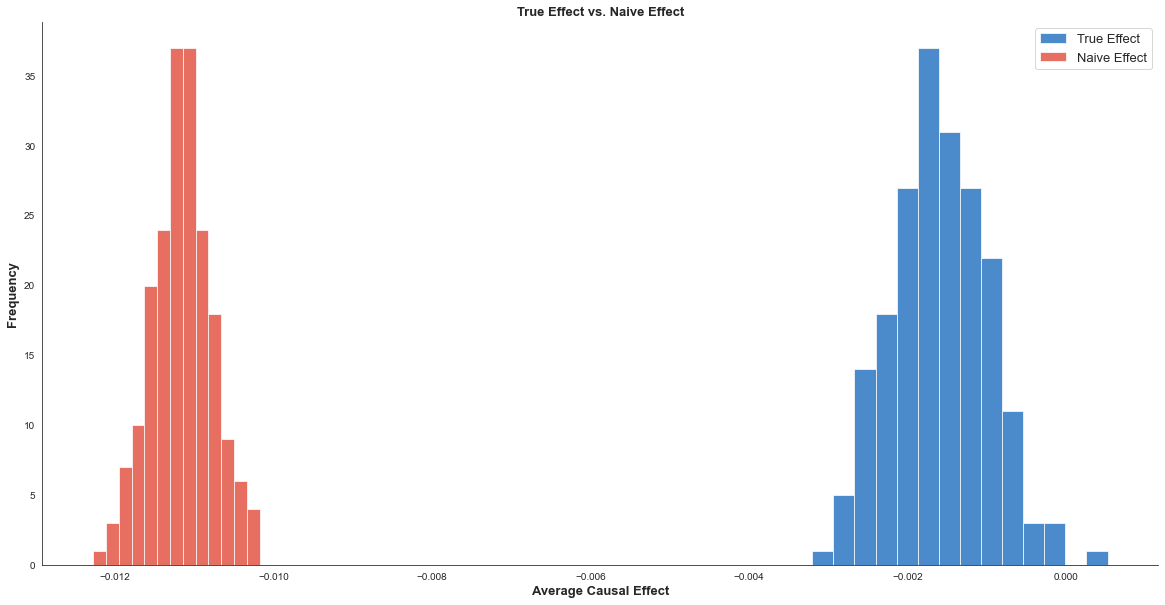

/Users/timsb/miniconda3/envs/causal2020/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


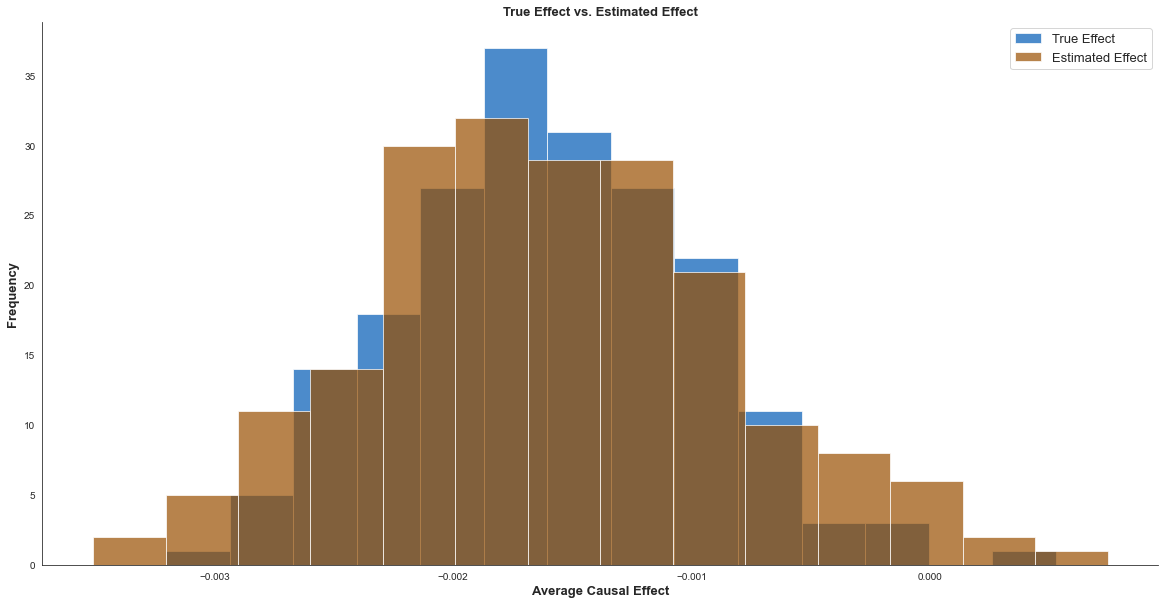

In [29]:
sns.set_style("white")

FONTSIZE = 13
HIST_ALPHA = 0.7

plt.figure(figsize=(20, 10))
sns.distplot(
    causal_effects.true_effect,
    label="True Effect",
    kde=False,
    color="#005AB5",
    hist_kws={"alpha": HIST_ALPHA},
)
sns.distplot(
    causal_effects.naive_effect,
    label="Naive Effect",
    kde=False,
    color="#DC3220",
    hist_kws={"alpha": HIST_ALPHA},
)
plt.title(
    "True Effect vs. Naive Effect",
    fontdict={"fontsize": FONTSIZE, "fontweight": "bold"},
)
plt.ylabel(
    "Frequency",
    rotation=90,
    labelpad=5,
    fontdict={"fontsize": FONTSIZE, "fontweight": "bold"},
)
plt.xlabel(
    "Average Causal Effect",
    fontdict={"fontsize": FONTSIZE, "fontweight": "bold"},
)
plt.legend(prop={"size": FONTSIZE})
sns.despine()
plt.savefig(TRUE_VS_NAIVE_PLOT_PATH, dpi=500, bbox_inches="tight")
if is_notebook():
    plt.show()

plt.figure(figsize=(20, 10))
sns.distplot(
    causal_effects.true_effect,
    label="True Effect",
    kde=False,
    color="#005AB5",
    hist_kws={"alpha": HIST_ALPHA},
)
sns.distplot(
    causal_effects.estimated_effect,
    label="Estimated Effect",
    kde=False,
    color="#994F00",
    hist_kws={"alpha": HIST_ALPHA},
)
plt.title(
    "True Effect vs. Estimated Effect",
    fontdict={"fontsize": FONTSIZE, "fontweight": "bold"},
)
plt.ylabel(
    "Frequency",
    rotation=90,
    labelpad=5,
    fontdict={"fontsize": FONTSIZE, "fontweight": "bold"},
)
plt.xlabel(
    "Average Causal Effect",
    fontdict={"fontsize": FONTSIZE, "fontweight": "bold"},
)
plt.legend(prop={"size": FONTSIZE})
sns.despine()
plt.savefig(TRUE_VS_ESTIMATED_PLOT_PATH, dpi=500, bbox_inches="tight")
if is_notebook():
    plt.show()

# Conclusion

The main conclusion from this notebook is that assigning causal intepretations to model parameters is only valid if we draw clear assumptions about the data generation process about the question at hand. The data generating process was shown to be important even as the outcome model remained unchanged. Drawing a causal graph (and testing its validity with the data at hand) allows one to clearly state their assumptions about the data generating process and to clearly assign causal interpretations to specific model parameters.